# Cell clustering notebook

NOTE: this notebook should be run after `example_pixel_clustering.ipynb`

In [ ]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import feather
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr

from ark.analysis import visualize
from ark.phenotyping import som_utils
from ark.utils import data_utils, io_utils, load_utils, plot_utils
from ark.utils.metacluster_remap_gui import MetaClusterData, MetaClusterGui, metaclusterdata_from_files

## 1: Load parameters for cell clustering (computed by `example_pixel_clustering.ipynb`)

`cell_clustering_params_name` should be in the form `{pixel_cluster_prefix}_cell_clustering_params.json` contained in `{pixel_cluster_prefix}_pixel_output_dir`. Make sure to set `base_dir` and `pixel_output_dir` to the same value used in `example_pixel_clustering.ipynb`.

NOTE: `{pixel_cluster_prefix}` is set in `example_pixel_clustering.ipynb`. If you did not explicity set a `{pixel_cluster_prefix}` in `example_pixel_clustering.ipynb`, the prefix defaults to the timestamp of the run. Please check the run directory (`base_dir` as set in `example_pixel_clustering.ipynb`) to see the prefix that was used.

In [ ]:
# define the home directory containing pixel_output_dir
base_dir = "../data/granulomaCohort_allData"

# define the name of the folder containing the pixel cluster data
pixel_output_dir = '2022-05-03T18:05:24_pixel_output_dir'

# define the name of the cell clustering params file
cell_clustering_params_name = '2022-05-03T18:05:24_cell_clustering_params.json'

The following params are loaded:

* `fovs`: the subset of fovs used for pixel clustering
* `channels`: the subset of channels used for pixel clustering
* `segmentation_dir`: the path to the directory containing your segmented images (generated from `Segment_Image_Data.ipynb`)
* `seg_suffix`: the suffix plus the file extension of the segmented images for each FOV
* `pixel_consensus_dir`: the name of the directory containing pixel data with the pixel SOM and consensus cluster assignments
* `pc_chan_avg_som_cluster_name`: the name of the file containing the average channel expression per pixel SOM cluster, used for the visualization of weighted channel average per cell
* `pc_chan_avg_meta_cluster_name`: the name of the file containing the average channel expression per pixel meta cluster, used for the visualization of weighted channel average per cell

Additionally, define the following param:

* `cell_table_name`: name of the cell table created by `Segment_Image_Data.ipynb`, should be placed in the root of `base_dir`. You can use either the normalized or arcsinh versions (the only columns from the cell table used are `fov`, `label`, and `cell_size`, so the clustering pipeline supports both).

In [ ]:
# load the params
with open(os.path.join(base_dir, pixel_output_dir, cell_clustering_params_name)) as fh:
    cell_clustering_params = json.load(fh)
    
# assign the params to variables
fovs = cell_clustering_params['fovs']
channels = cell_clustering_params['channels']
segmentation_dir = cell_clustering_params['segmentation_dir']
seg_suffix = cell_clustering_params['seg_suffix']
pixel_consensus_dir = cell_clustering_params['pixel_consensus_dir']
pc_chan_avg_som_cluster_name = cell_clustering_params['pc_chan_avg_som_cluster_name']
pc_chan_avg_meta_cluster_name = cell_clustering_params['pc_chan_avg_meta_cluster_name']

# define the cell table name
cell_table_name = 'cell_table_size_normalized.csv'

## 2: Cell clustering

### 2.1: train cell SOM

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used.

In [ ]:
# explicitly set cell_cluster_prefix to override datetime default
cell_cluster_prefix = None

if cell_cluster_prefix is None:
    cell_cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')

The following folders/files will be created with names prefixed by `cell_cluster_prefix`:

* `cell_output_dir`: the name of the folder to store the cell clustering directories/files
* `cell_clustered_name`: file to store cell data with just the cell SOM cluster assignments
* `cell_consensus_name`: file to store cell data with the cell SOM and consensus cluster assignments
* `cell_weights_name`: file name to place the cell SOM weights
* `cluster_counts_name`: file name to store the counts of each pixel SOM/meta clusters per cell
* `cluster_counts_norm_name`: same as above, except with each value normalized by the respective cell's size
* `weighted_cell_channel_name`: file name to store the weighted cell channel expression for each cell. Refer to <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.compute_p2c_weighted_channel_avg>cell channel weighting docs</a> for how the weighting is computed.
* `cell_clust_to_meta_name`: file name to store the mapping between cell SOM clusters and cell meta clusters
* `cell_som_cluster_count_avgs_name`: file name to store the average number of pixel SOM/meta clusters per cell SOM cluster
* `cell_meta_cluster_count_avgs_name`: same as above except for cell meta clusters
* `cell_som_cluster_channel_avg_name`: file name to store the average weighted channel expression per cell SOM cluster
* `cell_meta_cluster_channel_avg_name`: same as above except for cell meta clusters
* `cell_meta_cluster_remap_name`: for the meta cluster remapping process, the file to store the new SOM to meta mappings

In [ ]:
# define the base output cell folder
cell_output_dir = '%s_cell_output_dir' % cell_cluster_prefix
if not os.path.exists(os.path.join(base_dir, cell_output_dir)):
    os.mkdir(os.path.join(base_dir, cell_output_dir))
    
# define the paths to cell clustering files, explicitly set the variables to use custom names
cell_clustered_name = os.path.join(cell_output_dir, '%s_cell_mat_clustered.feather' % cell_cluster_prefix)
cell_consensus_name = os.path.join(cell_output_dir, '%s_cell_mat_consensus.feather' % cell_cluster_prefix)
cell_weights_name = os.path.join(cell_output_dir, '%s_cell_weights.feather' % cell_cluster_prefix)
cluster_counts_name = os.path.join(cell_output_dir, '%s_cluster_counts.feather' % cell_cluster_prefix)
cluster_counts_norm_name = os.path.join(cell_output_dir, '%s_cluster_counts_norm.feather' % cell_cluster_prefix)
weighted_cell_channel_name = os.path.join(cell_output_dir, '%s_weighted_cell_channel.csv' % cell_cluster_prefix)
cell_clust_to_meta_name = os.path.join(cell_output_dir, '%s_cell_clust_to_meta.feather' % cell_cluster_prefix)
cell_som_cluster_count_avgs_name = os.path.join(cell_output_dir, '%s_cell_som_cluster_count_avgs.csv' % cell_cluster_prefix)
cell_meta_cluster_count_avgs_name = os.path.join(cell_output_dir, '%s_cell_meta_cluster_count_avgs.csv' % cell_cluster_prefix)
cell_som_cluster_channel_avg_name = os.path.join(cell_output_dir, '%s_cell_som_cluster_channel_avg.csv' % cell_cluster_prefix)
cell_meta_cluster_channel_avg_name = os.path.join(cell_output_dir, '%s_cell_meta_cluster_channel_avg.csv' % cell_cluster_prefix)
cell_meta_cluster_remap_name = os.path.join(cell_output_dir, '%s_cell_meta_cluster_mapping.csv' % cell_cluster_prefix)

Additionally, define the following pixel cluster aggregation variable:

* `pixel_cluster_col`: whether to use pixel SOM or meta cluster counts for training/aggregating. Set to `'pixel_som_cluster'` or `'pixel_meta_cluster_rename'` respectively. Note that if you did not explicitly rename your pixel meta clusters in `example_pixel_clustering.ipynb`, the default numeric names will be used.

In [ ]:
# define the type of pixel cluster to aggregate on
pixel_cluster_col = 'pixel_meta_cluster_rename'

# depending on which pixel_cluster_col is selected, choose the pixel channel average table accordingly
if pixel_cluster_col == 'pixel_som_cluster':
    pc_chan_avg_name = pc_chan_avg_som_cluster_name
elif pixel_cluster_col == 'pixel_meta_cluster_rename':
    pc_chan_avg_name = pc_chan_avg_meta_cluster_name

Train the cell SOM on the normalized number of pixel SOM/meta clusters per cell (the data stored in `cluster_counts_norm_name`).  Training is done using the `FlowSOM` algorithm. Note that each of the pixel SOM/meta cluster columns are normalized by their 99.9% value prior to training.

Additionally, this function also computes the weighted cell channel table (the data stored in `weighted_cell_channel_name`). This data will be needed to compute the weighted average channel expression per cell cluster (the data stored in `cell_som_cluster_channel_avg_name` and `cell_meta_cluster_channel_avg_name`). See documentation of `compute_p2c_weighted_channel_avg` for how weighted cell channel average is computed: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.compute_p2c_weighted_channel_avg>cell channel weighting docs</a>.

For a full set of parameters you can customize for `train_cell_som`, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.train_cell_som>cell training docs</a>

In [ ]:
# create the cell-level SOM weights
som_utils.train_cell_som(
    fovs,
    channels,
    base_dir,
    pixel_consensus_dir=pixel_consensus_dir,
    cell_table_name=cell_table_name,
    cluster_counts_name=cluster_counts_name,
    cluster_counts_norm_name=cluster_counts_norm_name,
    pixel_cluster_col=pixel_cluster_col,
    pc_chan_avg_name=pc_chan_avg_name,
    weights_name=cell_weights_name,
    weighted_cell_channel_name=weighted_cell_channel_name,
    num_passes=10
)

### 2.2: assign cell SOM clusters

Use the weights learned from `train_cell_som` to assign cell clusters to the cell dataset. Note that this is done on the normalized pixel SOM/meta cluster counts table. As with `train_pixel_som`, each of the columns are normalized by their 99.9% value prior to assigning a cell SOM cluster label.

This function also computes the average number of pixel SOM/meta clusters per cell SOM cluster as well as the number of cells in each cell SOM cluster (the data placed in `cell_som_cluster_count_avgs_name`). This is needed for cell consensus clustering.

In [ ]:
# use cell SOM weights to assign cell clusters
som_utils.cluster_cells(
    base_dir,
    cluster_counts_norm_name=cluster_counts_norm_name,
    weights_name=cell_weights_name,
    cell_cluster_name=cell_clustered_name,
    pixel_cluster_col_prefix=pixel_cluster_col,
    cell_som_cluster_count_avgs_name=cell_som_cluster_count_avgs_name
)

### 2.3: run cell consensus clustering

With the SOM cluster labels assigned to the cell data, assign consensus cluster labels. The consensus clusters are trained on the average number of pixel SOM/meta clusters across all cell SOM clusters (the data stored in `cell_som_cluster_count_avgs_name`). These values are z-scored and capped at the value specified in the `cap` argument prior to training: this helps improve the meta clustering process.

After consensus clustering, the following are also computed:

* The average number of pixel SOM/meta clusters across all cell meta clusters, and the number of cells per meta cluster (the data placed in `cell_meta_cluster_count_avgs_name`)
* The meta cluster mapping for each cell SOM cluster in `cell_som_cluster_count_avgs_name` (data is resaved, same data except with an associated meta cluster column)
* The weighted channel average across all cell clusters (the data placed in `cell_som_cluster_channel_avgs_name` and `cell_meta_cluster_channel_avgs_name`). This will be done for both `'cell_som_cluster'` and `'cell_meta_cluster'`.

For a full set of parameters you can customize for `cell_consensus_cluster`, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.cell_consensus_cluster>cell consensus clustering docs</a>

* `max_k`: the number of consensus clusters desired
* `cap`: used to clip z-scored values prior to consensus clustering (in the range `[-cap, cap]`)

In [ ]:
max_k = 20
cap = 3

# run hierarchical clustering based on cell SOM cluster assignments
som_utils.cell_consensus_cluster(
    fovs=fovs,
    channels=channels,
    base_dir=base_dir,
    pixel_cluster_col=pixel_cluster_col,
    max_k=max_k,
    cap=cap,
    cell_cluster_name=cell_clustered_name,
    cell_som_cluster_count_avgs_name=cell_som_cluster_count_avgs_name,
    cell_meta_cluster_count_avgs_name=cell_meta_cluster_count_avgs_name,
    weighted_cell_channel_name=weighted_cell_channel_name,
    cell_som_cluster_channel_avg_name=cell_som_cluster_channel_avg_name,
    cell_meta_cluster_channel_avg_name=cell_meta_cluster_channel_avg_name,
    clust_to_meta_name=cell_clust_to_meta_name,
    cell_consensus_name=cell_consensus_name,
)

## 3: visualize results

### 3.1: use the interactive reclustering results to relabel cell meta clusters

The visualization shows the z-scored average pixel cluster count expression per cell SOM and meta cluster. The heatmaps are faceted by cell SOM clusters on the left and cell meta clusters on the right.

## Usage

### Quickstart
- **Select**: Left Click
- **Remap**: **New metacluster button** or Right Click
- **Edit Metacluster Name**: Textbox at bottom right of the heatmaps.

### Selection and Remapping details
- To select a SOM cluster, click on its respective position in the **selected** bar. Click on it again to deselect.
- To select a meta cluster, click on its corresponding color in the **metacluster** bar. Click on it again to deselect.
- To remap the selected clusters, click the **New metacluster** button (alternatively, right click anywhere). Note that remapping an entire metacluster deletes it.
- To clear the selected SOM/meta clusters, use the **Clear Selection** button.
- **After remapping a meta cluster, make sure to deselect the newly created one to prevent unwanted combinations.**

### Other features and notes
- You will likely need to zoom out to see the entire visualization. To toggle Zoom, use Ctrl -/Ctrl + on Windows or ⌘ +/⌘ - on Mac.
- The bars at the top show the number of cells in each SOM cluster.
- The text box at the bottom right allows you to rename a particular meta cluster. This can be useful as remapping may cause inconsistent numbering.
- Adjust the z-score limit using the slider on the bottom left to adjust your dynamic range.
- When meta clusters are combined or a meta cluster is renamed, the change is immediately saved to `cell_meta_cluster_remap_name`.
- You won't be able to advance until you've clicked `New metacluster` or renamed a meta cluster at least once. If you do not want to make changes, just click `New metacluster` to trigger a save before continuing.

In [10]:
%matplotlib widget
plt.ion()

cell_mcd = metaclusterdata_from_files(
    os.path.join(base_dir, cell_som_cluster_count_avgs_name),
    cluster_type='cell',
    prefix_trim='pixel_meta_cluster_rename_'
)
cell_mcd.output_mapping_filename = os.path.join(base_dir, cell_meta_cluster_remap_name)
cell_mcg = MetaClusterGui(cell_mcd, width=17)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

Relabel the cell meta clusters using the mapping.

In [ ]:
som_utils.apply_cell_meta_cluster_remapping(
    fovs,
    channels,
    base_dir,
    cell_consensus_name,
    cell_meta_cluster_remap_name,
    pixel_cluster_col,
    cell_som_cluster_count_avgs_name,
    cell_meta_cluster_count_avgs_name,
    weighted_cell_channel_name,
    cell_som_cluster_channel_avg_name,
    cell_meta_cluster_channel_avg_name
)

Generate the color scheme returned by the interactive reclustering process. This will be for visualizing the weighted channel average heatmaps and the cell cluster overlay.

In [ ]:
raw_cmap, renamed_cmap = som_utils.generate_meta_cluster_colormap_dict(
    cell_mcd.output_mapping_filename,
    cell_mcg.im_cl.cmap
)

### 3.2: weighted cell SOM cluster average heatmap over channels (z-scored)

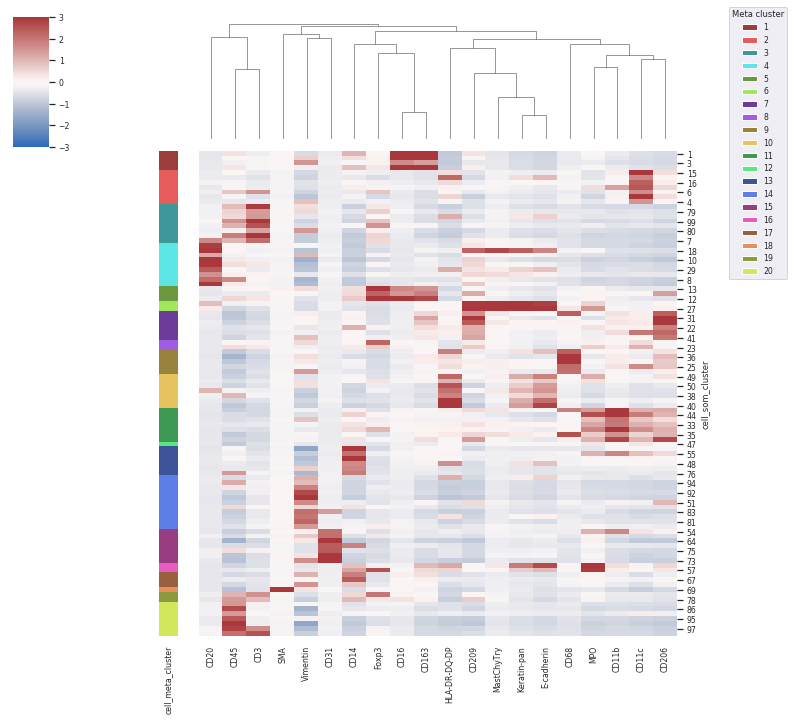

In [14]:
%matplotlib inline
som_utils.generate_weighted_channel_avg_heatmap(
    os.path.join(base_dir, cell_som_cluster_channel_avg_name),
    'cell_som_cluster',
    channels,
    raw_cmap,
    renamed_cmap
)

### 3.3: weighted cell meta cluster average heatmap over channels (z-scored)

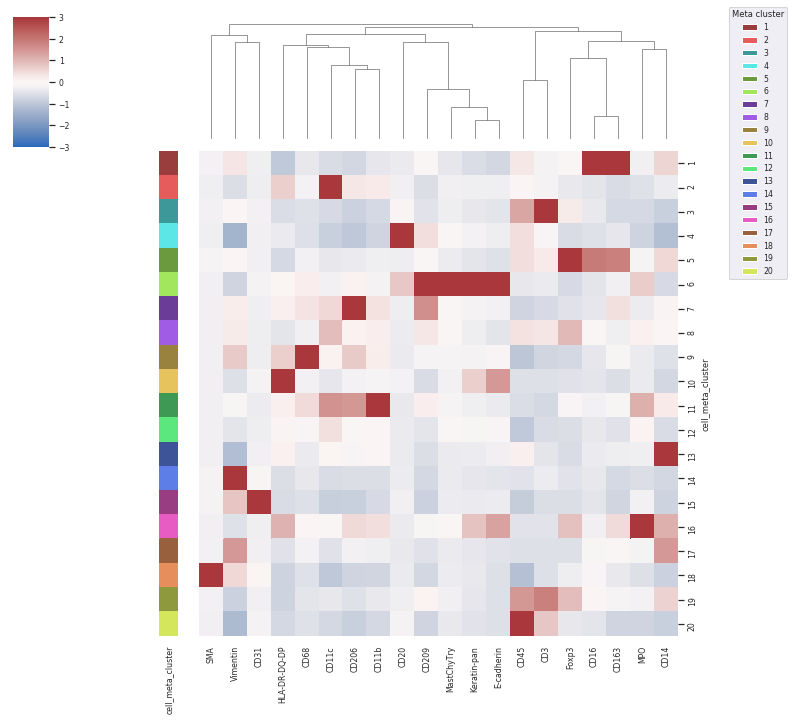

In [15]:
%matplotlib inline
som_utils.generate_weighted_channel_avg_heatmap(
    os.path.join(base_dir, cell_meta_cluster_channel_avg_name),
    'cell_meta_cluster',
    channels,
    raw_cmap,
    renamed_cmap
)

### 3.4: cell cluster overlay (cell meta clusters only)

In [ ]:
# select fovs to display
cell_fovs = ['fov6', 'fov7']

In [ ]:
# generate the cell cluster masks for each fov in cell_fovs
cell_cluster_masks = data_utils.generate_cell_cluster_mask(
    cell_fovs,
    base_dir,
    segmentation_dir,
    cell_consensus_name=cell_consensus_name,
    cell_cluster_col='cell_meta_cluster',
    seg_suffix=seg_suffix
)

* `save_cell_masks`: replace with `True` if you want to save, files will be written as `{fov_name}_cell_mask.tiff` in `base_dir`

In [ ]:
save_cell_masks = False

if save_cell_masks:
    data_utils.save_fov_images(
        cell_fovs,
        os.path.join(base_dir, cell_output_dir),
        cell_cluster_masks,
        name_suffix='_cell_mask'
    )

/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:217: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


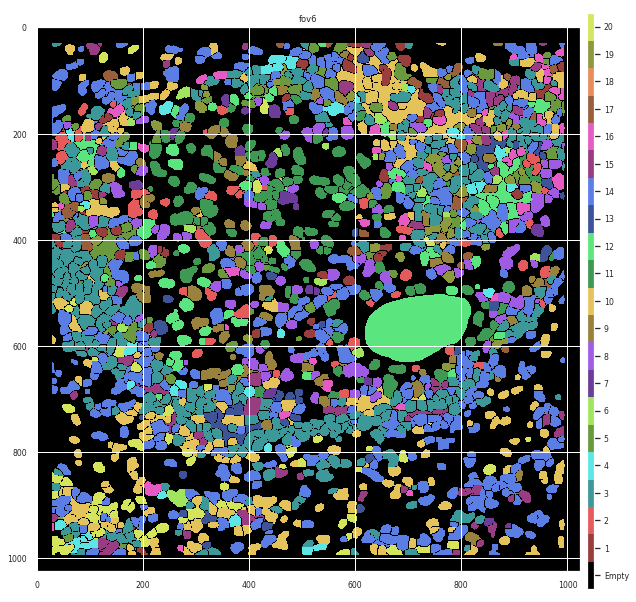

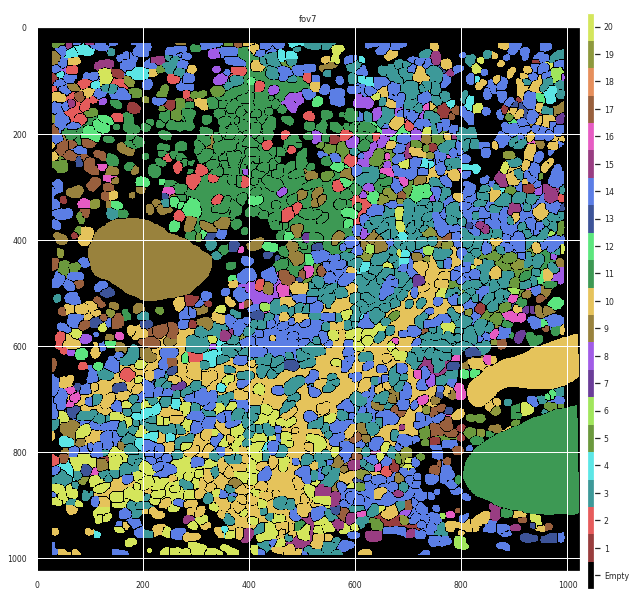

In [19]:
%matplotlib inline
plot_utils.plot_pixel_cell_cluster_overlay(
    cell_cluster_masks,
    cell_fovs,
    os.path.join(base_dir, cell_meta_cluster_remap_name),
    metacluster_colors=raw_cmap
)